# Computer Vision CSCI-GA.2272-001 Assignment 1, part 2.

Fall 2021 semester.

Due date: **September 30th 2021.**

## Introduction
This assignment requires you to participate in a Kaggle competition with the rest of the class on the The German Traffic Sign Recognition Benchmark [http://benchmark.ini.rub.de/?section=gtsrb&subsection=news]. The objective is to produce a model that gives the highest possible accuracy on the test portion of this dataset. You can register for the competition using the private link: https://www.kaggle.com/c/nyu-computer-vision-csci-ga2271-2021/overview.

Skeleton code is provided in the colab below. This contains code for training a simple default model and evaluating it on the test set. The evaluation script produces a file gtsrb_kaggle.csv that lists the IDs of the test set images, along with their predicted label. This file should be uploaded to the Kaggle webpage, which will then produce a test accuracy score. 

Your goal is to implement a new model architecture that improves upon the baseline performance. You are free to implement any approach covered in class or from research papers. This part will count for 50% of the overall grade for assignment 1. This Grading will depend on your Kaggle performance and rank, as well as novelty of the architecture.  

## Rules
You should make a copy of this Colab (File->Save a copy in Drive). Please start the assignment early and don’t be afraid to ask for help from either the TAs or myself. You are allowed to collaborate with other students in terms discussing ideas and possible solutions. However you code up the solution yourself, i.e. you must write your own code. Copying your friends code and just changing all the names of the variables is not allowed! You are not allowed to use solutions from similar assignments in courses from other institutions, or those found elsewhere on the web.
Your solutions should be submitted via the Brightspace system. This should include a brief description (in the Colab) explaining the model architectures you explored, citing any relevant papers or techniques that you used. You should also include convergence plots of training accuracy vs epoch for relevant models. 

### Important Details
• You are only allowed eight (8) submissions to the Kaggle evaluation server per day. This is to prevent over-fitting on the test dataset. So be sure to start the assignment early!

• You are NOT ALLOWED to use the test set labels during training in any way. Doing so will be regarded as cheating and penalized accordingly.

• The evaluation metric is accuracy, i.e. the fraction of test set examples where the predicted label agrees with the ground truth label.

• You should be able to achieve a test accuracy of at least 0.95. 

• *Extra important:* Please use your NYU NetID as your Kaggle username, so the TAs can figure out which user you are on the leaderboard. 


# Dataset Preparation


1.  Download `dataset.zip` from to your local machine.
2.  Unzip the file. You should see a `dataset` directory with three subfolders (`training,validation,testing`). 
3.  Go to Google Drive (on your NYU account) and make a directory `assign2_dataset` (New button --> New Folder).
4.  Upload each of the three subfolders to it (New button --> Folder upload). 
5.  Run the code block below. It will ask for permission to mount your Google Drive (NYU account) so this colab can access it. Paste the authorization code into the box as requested. 


In [55]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')
%cd  /content/drive/'My Drive'/assign2_dataset/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/assign2_dataset


In [56]:
import matplotlib.pyplot as plt
import numpy as np

def plotAccuracy(data1,data2):

  t = np.arange(0.0, len(data1), 1)
  s = data1

  fig, ax = plt.subplots()
  ax.plot(t, data1)
  ax.plot(t, data2)
  plt.legend(["Training accuracy", "Validation accuracy"])

  ax.set(xlabel='Number of Epochs', ylabel='Accuracy',
        title='Convergence plots of accuracy')
  ax.grid()

  plt.show()


# Test Model 97.53% accuracy

In [57]:
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau


batch_size = 32
momentum = 0.9
lr = 0.001
epochs = 200
log_interval = 1000

# batch_size = 32
# momentum = 0.9
# lr = 0.001
# epochs = 200
# log_interval = 1000

class MyDataset(Dataset):

    def __init__(self, X_path="X.pt", y_path="y.pt"):
        self.X = torch.load(X_path).squeeze(1)
        self.y = torch.load(y_path).squeeze(1)
    
    def __len__(self):
        return self.X.size(0)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = MyDataset(X_path="train/X.pt", y_path="train/y.pt")
val_dataset = MyDataset(X_path="validation/X.pt", y_path="validation/y.pt")

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=1)

val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=True, num_workers=1)

In [58]:
import torch
import torch.nn as nn
import torch.nn.functional as F

nclasses = 43 # GTSRB has 43 classes

# 97.53
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3)
        self.bn1=nn.BatchNorm2d(16)
        self.conv_drop1 = nn.Dropout(p=0.4)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3)
        self.bn2=nn.BatchNorm2d(32)
        self.conv_drop2 = nn.Dropout(p=0.4)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3)
        self.bn3=nn.BatchNorm2d(64)
        self.conv_drop3 = nn.Dropout(p=0.4)
        self.fc1 = nn.Linear(2*2*64, 50)
        self.fc2 = nn.Linear(50, nclasses)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2,stride=2))
        x = self.bn1(x)
        x = self.conv_drop1(x)
        x = F.relu(F.max_pool2d(self.conv2(x), 2,stride=2))
        x = self.bn2(x)
        x = self.conv_drop2(x)
        x = F.relu(F.max_pool2d(self.conv3(x), 2,stride=2))
        x = self.bn3(x)
        x = self.conv_drop3(x)
        x = torch.flatten(x,1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x,dim=1)

Train Epoch: 1 [0/35339 (0%)]	Loss: 3.898978
Train Epoch: 1 [32000/35339 (90%)]	Loss: 0.974657

Validation set: Average loss: 1.4024, Accuracy: 2224/3870 (57%)


Saved model to model_1.pth.
Train Epoch: 2 [0/35339 (0%)]	Loss: 1.246889
Train Epoch: 2 [32000/35339 (90%)]	Loss: 0.984643

Validation set: Average loss: 0.8236, Accuracy: 2812/3870 (73%)


Saved model to model_2.pth.
Train Epoch: 3 [0/35339 (0%)]	Loss: 0.892753
Train Epoch: 3 [32000/35339 (90%)]	Loss: 0.967408

Validation set: Average loss: 0.5904, Accuracy: 3209/3870 (83%)


Saved model to model_3.pth.
Train Epoch: 4 [0/35339 (0%)]	Loss: 0.890057
Train Epoch: 4 [32000/35339 (90%)]	Loss: 0.526221

Validation set: Average loss: 0.5354, Accuracy: 3190/3870 (82%)


Saved model to model_4.pth.
Train Epoch: 5 [0/35339 (0%)]	Loss: 0.565012
Train Epoch: 5 [32000/35339 (90%)]	Loss: 0.507315

Validation set: Average loss: 0.4705, Accuracy: 3324/3870 (86%)


Saved model to model_5.pth.
Train Epoch: 6 [0/35339 (0%)]	Loss: 0.581437
Train

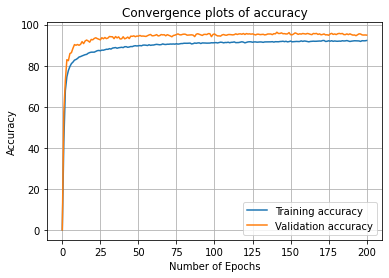

In [59]:
model = Net()
model.cuda()
optimizer = optim.Adam(model.parameters(), lr=lr)
# optimizer=optim.SGD(model.parameters(), lr=lr, momentum=momentum)
# scheduler = ReduceLROnPlateau(optimizer, 'min',factor=0.6,min_lr=0.00001,patience=10)
# scheduler = ReduceLROnPlateau(optimizer, 'min',0.6)

trainingAccuracy=[0]
def train(epoch):
    model.train()
    correct=0
    for batch_idx, (data, target) in enumerate(train_loader):
        data=data.cuda()
        target=target.cuda()
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
    trainingAccuracy.append(100. * correct / len(train_loader.dataset))

validationAccuracy=[0]
def validation():
    model.eval()
    validation_loss = 0
    correct = 0
    for data, target in val_loader:
        data=data.cuda()
        target=target.cuda()
        output = model(data)
        validation_loss += F.nll_loss(output, target, reduction="sum").item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        
    validation_loss /= len(val_loader.dataset)
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        validation_loss, correct, len(val_loader.dataset),
        100. * correct / len(val_loader.dataset)))
    validationAccuracy.append(100. * correct / len(val_loader.dataset))
    return validation_loss
    

for epoch in range(1, epochs + 1):
    train(epoch)
    validation_loss=validation()
    # scheduler.step(validation_loss)

    model_file = 'model_' + str(epoch) + '.pth'
    torch.save(model.state_dict(), model_file)
    print('\nSaved model to ' + model_file + '.')

plotAccuracy(trainingAccuracy,validationAccuracy)

## Test Model:

# Accuracy of 97.53% in Kaggle. 

# Final Model - 98.828% 


In [50]:
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau


batch_size = 32
momentum = 0.9
lr = 0.001
epochs = 120
log_interval = 1000

class MyDataset(Dataset):

    def __init__(self, X_path="X.pt", y_path="y.pt"):
        self.X = torch.load(X_path).squeeze(1)
        self.y = torch.load(y_path).squeeze(1)
    
    def __len__(self):
        return self.X.size(0)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = MyDataset(X_path="train/X.pt", y_path="train/y.pt")
val_dataset = MyDataset(X_path="validation/X.pt", y_path="validation/y.pt")

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=1)

val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=True, num_workers=1)

In [51]:
import torch
import torch.nn as nn
import torch.nn.functional as F

nclasses = 43 # GTSRB has 43 classes

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3)
        self.bn1=nn.BatchNorm2d(64)
        self.conv_drop1 = nn.Dropout(p=0.5)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3)
        self.bn2=nn.BatchNorm2d(128)
        self.conv_drop2 = nn.Dropout(p=0.5)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3)
        self.bn3=nn.BatchNorm2d(256)
        self.conv_drop3 = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(2*2*256, 50)
        self.fc2 = nn.Linear(50, nclasses)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2,stride=2))
        x = self.bn1(x)
        x = self.conv_drop1(x)
        x = F.relu(F.max_pool2d(self.conv2(x), 2,stride=2))
        x = self.bn2(x)

        x = self.conv_drop2(x)
        x = F.relu(F.max_pool2d(self.conv3(x), 2,stride=2))
        x = self.bn3(x)
        x = self.conv_drop3(x)
        x = torch.flatten(x,1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x,dim=1)

Train Epoch: 1 [0/35339 (0%)]	Loss: 3.893208
Train Epoch: 1 [32000/35339 (90%)]	Loss: 1.338948

Validation set: Average loss: 0.6341, Accuracy: 3120/3870 (81%)


Saved model to model_1.pth.
Train Epoch: 2 [0/35339 (0%)]	Loss: 0.635057
Train Epoch: 2 [32000/35339 (90%)]	Loss: 0.438368

Validation set: Average loss: 0.3269, Accuracy: 3483/3870 (90%)


Saved model to model_2.pth.
Train Epoch: 3 [0/35339 (0%)]	Loss: 0.191826
Train Epoch: 3 [32000/35339 (90%)]	Loss: 0.287697

Validation set: Average loss: 0.2655, Accuracy: 3589/3870 (93%)


Saved model to model_3.pth.
Train Epoch: 4 [0/35339 (0%)]	Loss: 0.463939
Train Epoch: 4 [32000/35339 (90%)]	Loss: 0.281712

Validation set: Average loss: 0.2149, Accuracy: 3662/3870 (95%)


Saved model to model_4.pth.
Train Epoch: 5 [0/35339 (0%)]	Loss: 0.428407
Train Epoch: 5 [32000/35339 (90%)]	Loss: 0.407628

Validation set: Average loss: 0.1818, Accuracy: 3676/3870 (95%)


Saved model to model_5.pth.
Train Epoch: 6 [0/35339 (0%)]	Loss: 0.147882
Train

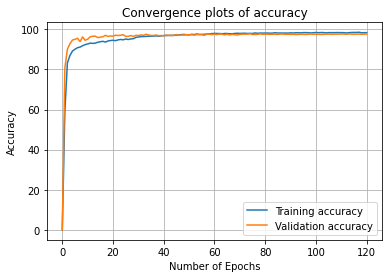

In [52]:
model = Net()
model.cuda()
optimizer = optim.Adam(model.parameters(), lr=lr)
# optimizer=optim.SGD(model.parameters(), lr=lr, momentum=momentum)
# scheduler = ReduceLROnPlateau(optimizer, 'min',factor=0.6,min_lr=0.00001,patience=10)
scheduler = ReduceLROnPlateau(optimizer, 'min',0.6)

trainingAccuracy=[0]
def train(epoch):
    model.train()
    correct=0
    for batch_idx, (data, target) in enumerate(train_loader):
        data=data.cuda()
        target=target.cuda()
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
    trainingAccuracy.append(100. * correct / len(train_loader.dataset))

validationAccuracy=[0]
def validation():
    model.eval()
    validation_loss = 0
    correct = 0
    for data, target in val_loader:
        data=data.cuda()
        target=target.cuda()
        output = model(data)
        validation_loss += F.nll_loss(output, target, reduction="sum").item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        
    validation_loss /= len(val_loader.dataset)
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        validation_loss, correct, len(val_loader.dataset),
        100. * correct / len(val_loader.dataset)))
    validationAccuracy.append(100. * correct / len(val_loader.dataset))
    return validation_loss
    

for epoch in range(1, epochs + 1):
    train(epoch)
    validation_loss=validation()
    scheduler.step(validation_loss)

    model_file = 'model_' + str(epoch) + '.pth'
    torch.save(model.state_dict(), model_file)
    print('\nSaved model to ' + model_file + '.')

plotAccuracy(trainingAccuracy,validationAccuracy)

## Final Model: 

# Accuracy of 98.828% in Kaggle.

# Evaluate and Submit to Kaggle



In [9]:
import pickle
import pandas as pd

outfile = 'gtsrb_kaggle.csv'

output_file = open(outfile, "w")
dataframe_dict = {"Filename" : [], "ClassId": []}

test_data = torch.load('testing/test.pt')
file_ids = pickle.load(open('testing/file_ids.pkl', 'rb'))
model = Net() # TODO: load your model here, don't forget to put it on Eval mode !
model.load_state_dict(torch.load("model_120.pth"))
model.eval()
for i, data in enumerate(test_data):
    data = data.unsqueeze(0)

    output = model(data)
    pred = output.data.max(1, keepdim=True)[1].item()
    file_id = file_ids[i][0:5]
    dataframe_dict['Filename'].append(file_id)
    dataframe_dict['ClassId'].append(pred)

df = pd.DataFrame(data=dataframe_dict)
df.to_csv(outfile, index=False)
print("Written to csv file {}".format(outfile))

Written to csv file gtsrb_kaggle.csv


# Design and motivation

Firstly, I tried the given model which gave an accuracy of 70%. 
Then I started reading different architectures and found [LeNet-5](https://towardsdatascience.com/understanding-and-implementing-lenet-5-cnn-architecture-deep-learning-a2d531ebc342) architecture interesting, and tried to improvise it by adding one more convolutional layer. 

Later I experimented with activation function **ReLu** and tried different prbabilites of **dropout** after each layer (except the last one) to avoid overfitting, inspired by **Alexnet**.

Further, applying batch normalization to each layer and increasing the depth of the layers helped increase the accuracy to 97.5% in Kaggle.

Changed number of filters from 16->32->64 to 64->128->256.

Lastly,
I found that learning rate decay is a technique for training modern neural networks. It starts with a large learning rate and then decays it multiple times. It is empirically observed to help both optimization and generalization. Common beliefs in how lrDecay works come from the optimization analysis of (Stochastic) Gradient Descent: 


1. an initially large learning rate accelerates training or helps the network escape spurious local minima.
2. decaying the learning rate helps the network converge to a local minimum and avoid oscillation.

Ref: [How Does Learning Rate Decay Help Modern Neural Networks?](https://openreview.net/attachment?id=r1eOnh4YPB&name=original_pdf)

So, I tried multi-step learning rate scheduler, where I was decaying the learning rate when accuracy started to plateau which helped a bit. Monitoring and caliberating multi-step LR is a tedious process and might even not be possible in case of large number of epochs. 

I was looking to further fine tune my model and came across 

```
scheduler = ReduceLROnPlateau(optimizer, 'min',0.6)
```
which adjusts the learning rate when a plateau in model performance is detected, e.g. no change for a given number of training epochs. 

Ref: [Understand the Impact of Learning Rate on Neural Network Performance](https://machinelearningmastery.com/understand-the-dynamics-of-learning-rate-on-deep-learning-neural-networks/)

Finally, I got the score of **98.828%** in Kaggle.
